### # 🔹 Model Explainability Report — SHAP + Feature Importance + ROC
##### This notebook visualizes model explainability for **Fraud** and **Credit Card** Random Forest models.


### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import shap
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

plt.style.use("seaborn-v0_8")


### Paths & Model Config

In [3]:
FRAUD_TEST_PATH = "../data/processed/fraud_test_fe.csv"
CC_TEST_PATH = "../data/processed/creditcard_test_fe.csv"

MODEL_DIR = "models"

# Point to models folder OUTSIDE the notebook directory
MODEL_DIR = os.path.abspath(os.path.join("..", "models"))

FRAUD_RF = os.path.join(MODEL_DIR, "fraud_rf.pkl")
FRAUD_SCALER = os.path.join(MODEL_DIR, "fraud_scaler.pkl")

CC_RF = os.path.join(MODEL_DIR, "creditcard_rf.pkl")
CC_SCALER = os.path.join(MODEL_DIR, "creditcard_scaler.pkl")

FRAUD_TARGET = "class"
CC_TARGET = "Class"

### Load Datasets

In [4]:
fraud_test = pd.read_csv(FRAUD_TEST_PATH)
cc_test = pd.read_csv(CC_TEST_PATH)

X_fraud = fraud_test.drop(columns=[FRAUD_TARGET])
y_fraud = fraud_test[FRAUD_TARGET]

X_cc = cc_test.drop(columns=[CC_TARGET])
y_cc = cc_test[CC_TARGET]

# ##  Load Models & Scalers
fraud_rf = joblib.load(FRAUD_RF)
fraud_scaler = joblib.load(FRAUD_SCALER)

cc_rf = joblib.load(CC_RF)
cc_scaler = joblib.load(CC_SCALER)

print("✅ Models and datasets loaded")

✅ Models and datasets loaded


### Scale Features

In [5]:
X_fraud_scaled = fraud_scaler.transform(X_fraud)
X_cc_scaled = cc_scaler.transform(X_cc)

# ## 6️⃣ Stratified Sampling for SHAP (speed + stability)
N = 200  # number of samples for SHAP

X_fraud_s, _, y_fraud_s, _ = train_test_split(
    X_fraud_scaled, y_fraud.values, train_size=N, stratify=y_fraud.values, random_state=42
)

X_cc_s, _, y_cc_s, _ = train_test_split(
    X_cc_scaled, y_cc.values, train_size=N, stratify=y_cc.values, random_state=42
)

### SHAP Explainers (interventional = stable)

In [6]:
explainer_fraud = shap.TreeExplainer(fraud_rf, feature_perturbation="interventional")
explainer_cc = shap.TreeExplainer(cc_rf, feature_perturbation="interventional")

# Compute SHAP values
shap_values_fraud = explainer_fraud.shap_values(X_fraud_s, check_additivity=False)
shap_values_cc = explainer_cc.shap_values(X_cc_s, check_additivity=False)

print("✅ SHAP values computed")

c:\Users\Administrator\Downloads\week12 new\Improved-detection-of-fraud-cases-for-e-commerce-and-bank-transactions-updated\.venv\Lib\site-packages\shap\explainers\_tree.py:254: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


✅ SHAP values computed


### Fraud Dataset — SHAP Feature Importance & Beeswarm

Raw SHAP shape: (200, 191, 2)
Final SHAP shape: (200, 191)


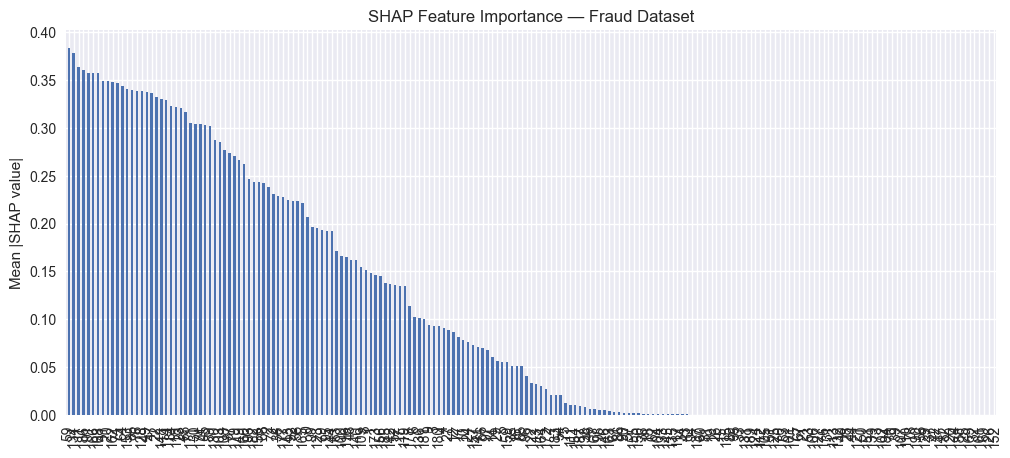

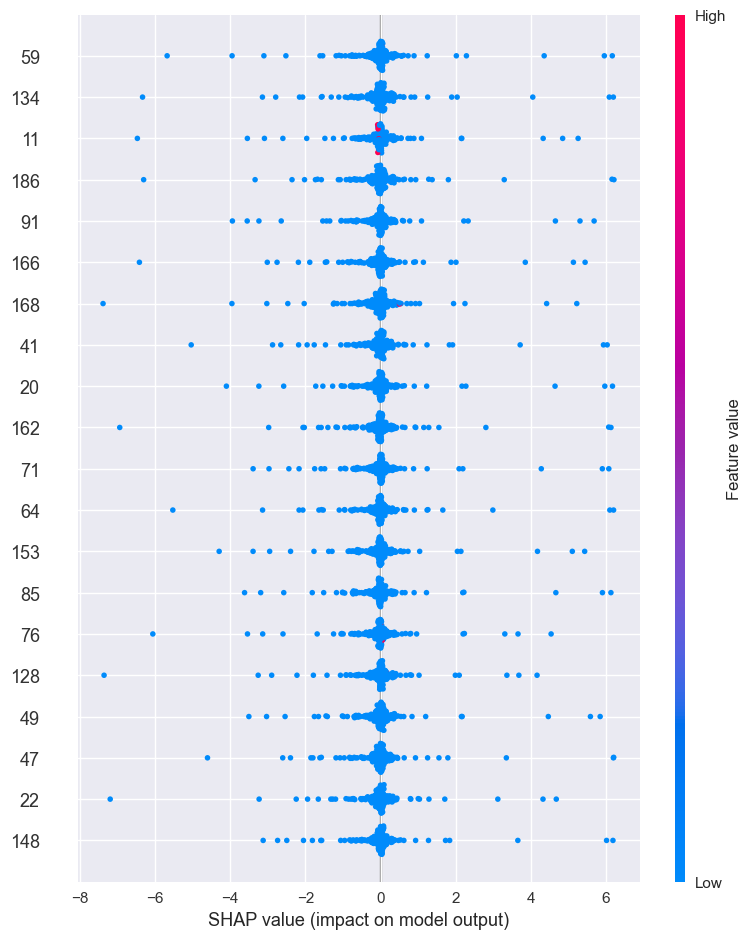

In [12]:
# ================= FRAUD SHAP FEATURE IMPORTANCE =================

# Convert to numpy
shap_fraud = np.array(shap_values_fraud)

print("Raw SHAP shape:", shap_fraud.shape)

# If 3D → collapse class dimension
# Expected: (samples, features, classes)
if shap_fraud.ndim == 3:
    shap_fraud = shap_fraud[:, :, 1]   # positive class

print("Final SHAP shape:", shap_fraud.shape)

# Build dataframe from SAME samples
X_fraud_df = pd.DataFrame(X_fraud_s, columns=X_fraud.columns)

# Align columns safely
min_cols = min(shap_fraud.shape[1], X_fraud_df.shape[1])
shap_fraud = shap_fraud[:, :min_cols]
X_fraud_df = X_fraud_df.iloc[:, :min_cols]

# ================= BAR PLOT =================

mean_abs_shap = np.mean(np.abs(shap_fraud), axis=0)

shap_importance = pd.Series(
    mean_abs_shap,
    index=X_fraud_df.columns
).sort_values(ascending=False)

plt.figure(figsize=(12,5))
shap_importance.plot(kind="bar")
plt.title("SHAP Feature Importance — Fraud Dataset")
plt.ylabel("Mean |SHAP value|")
plt.show()

# ================= BEESWARM =================

shap.summary_plot(shap_fraud, X_fraud_df)


### Credit Card Dataset — SHAP Feature Importance & Beeswarm

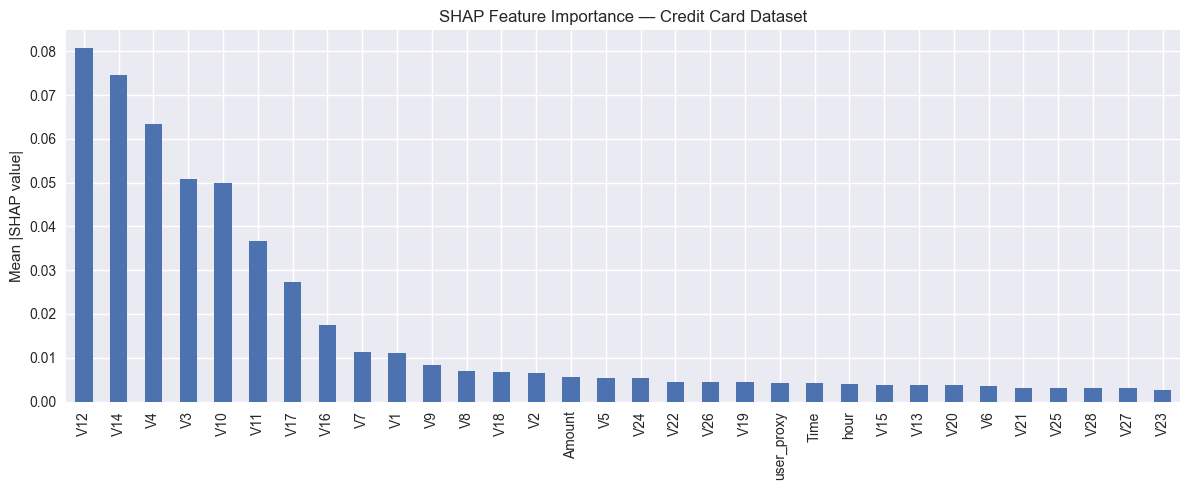

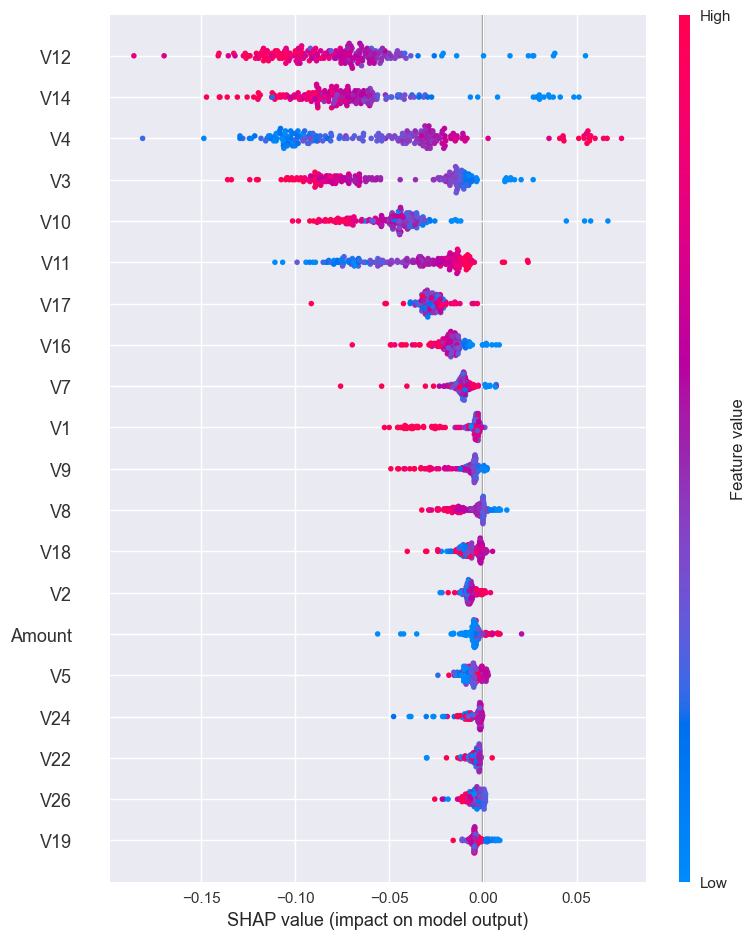

In [9]:
# Handle binary SHAP output properly (select class 1)
if isinstance(shap_values_cc, list):
    shap_cc = shap_values_cc[1]   # class 1
else:
    shap_cc = shap_values_cc[..., 1] if shap_values_cc.ndim == 3 else shap_values_cc

shap_cc = np.array(shap_cc)

# Create dataframe
X_cc_df = pd.DataFrame(X_cc_s, columns=X_cc.columns)

# Safety alignment
min_cols = min(shap_cc.shape[1], X_cc_df.shape[1])
shap_cc = shap_cc[:, :min_cols]
X_cc_df = X_cc_df.iloc[:, :min_cols]

# -------- BAR PLOT --------
mean_abs_shap_cc = np.mean(np.abs(shap_cc), axis=0)

shap_importance_cc = pd.Series(
    mean_abs_shap_cc,
    index=X_cc_df.columns
).sort_values(ascending=False)

plt.figure(figsize=(12,5))
shap_importance_cc.plot(kind="bar")
plt.title("SHAP Feature Importance — Credit Card Dataset")
plt.ylabel("Mean |SHAP value|")
plt.tight_layout()
plt.show()

# -------- BEESWARM --------
shap.summary_plot(shap_cc, X_cc_df)


### ROC Curves

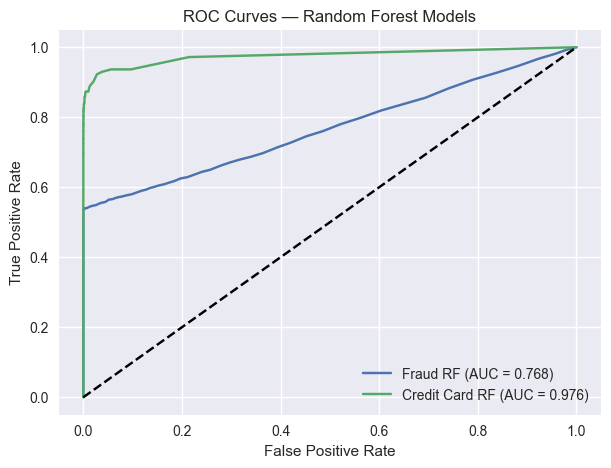

In [13]:
y_fraud_pred_prob = fraud_rf.predict_proba(X_fraud_scaled)[:,1]
fpr_fraud, tpr_fraud, _ = roc_curve(y_fraud, y_fraud_pred_prob)
roc_auc_fraud = auc(fpr_fraud, tpr_fraud)

y_cc_pred_prob = cc_rf.predict_proba(X_cc_scaled)[:,1]
fpr_cc, tpr_cc, _ = roc_curve(y_cc, y_cc_pred_prob)
roc_auc_cc = auc(fpr_cc, tpr_cc)

plt.figure(figsize=(7,5))
plt.plot(fpr_fraud, tpr_fraud, label=f"Fraud RF (AUC = {roc_auc_fraud:.3f})")
plt.plot(fpr_cc, tpr_cc, label=f"Credit Card RF (AUC = {roc_auc_cc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Random Forest Models")
plt.legend()
plt.show()


### Random Forest Feature Importances (Top 15)


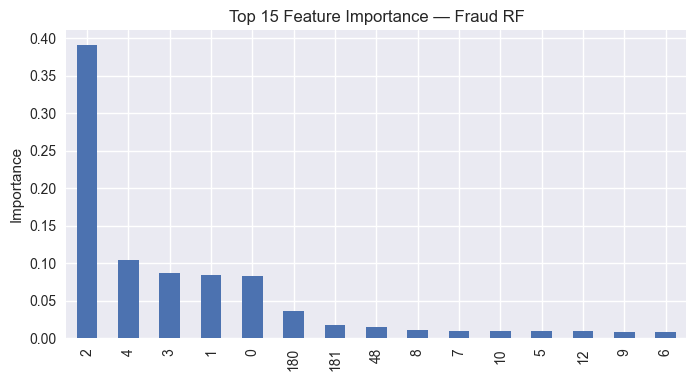

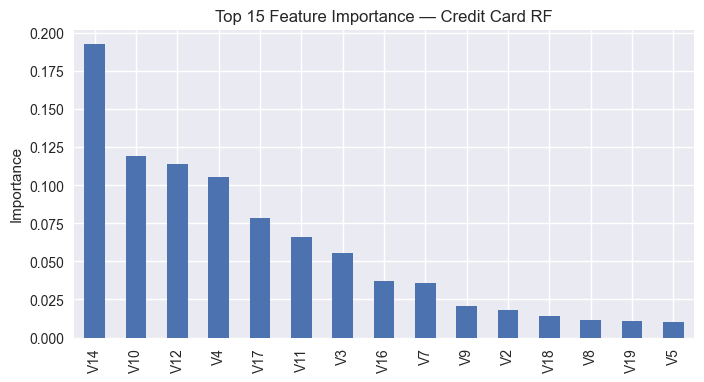

In [14]:
# Fraud
rf_fraud_imp = pd.Series(fraud_rf.feature_importances_, index=X_fraud.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
rf_fraud_imp.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importance — Fraud RF")
plt.ylabel("Importance")
plt.show()

# Credit Card
rf_cc_imp = pd.Series(cc_rf.feature_importances_, index=X_cc.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
rf_cc_imp.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importance — Credit Card RF")
plt.ylabel("Importance")
plt.show()

### 🔹 Side-by-Side SHAP Comparison — Fraud vs Credit Card

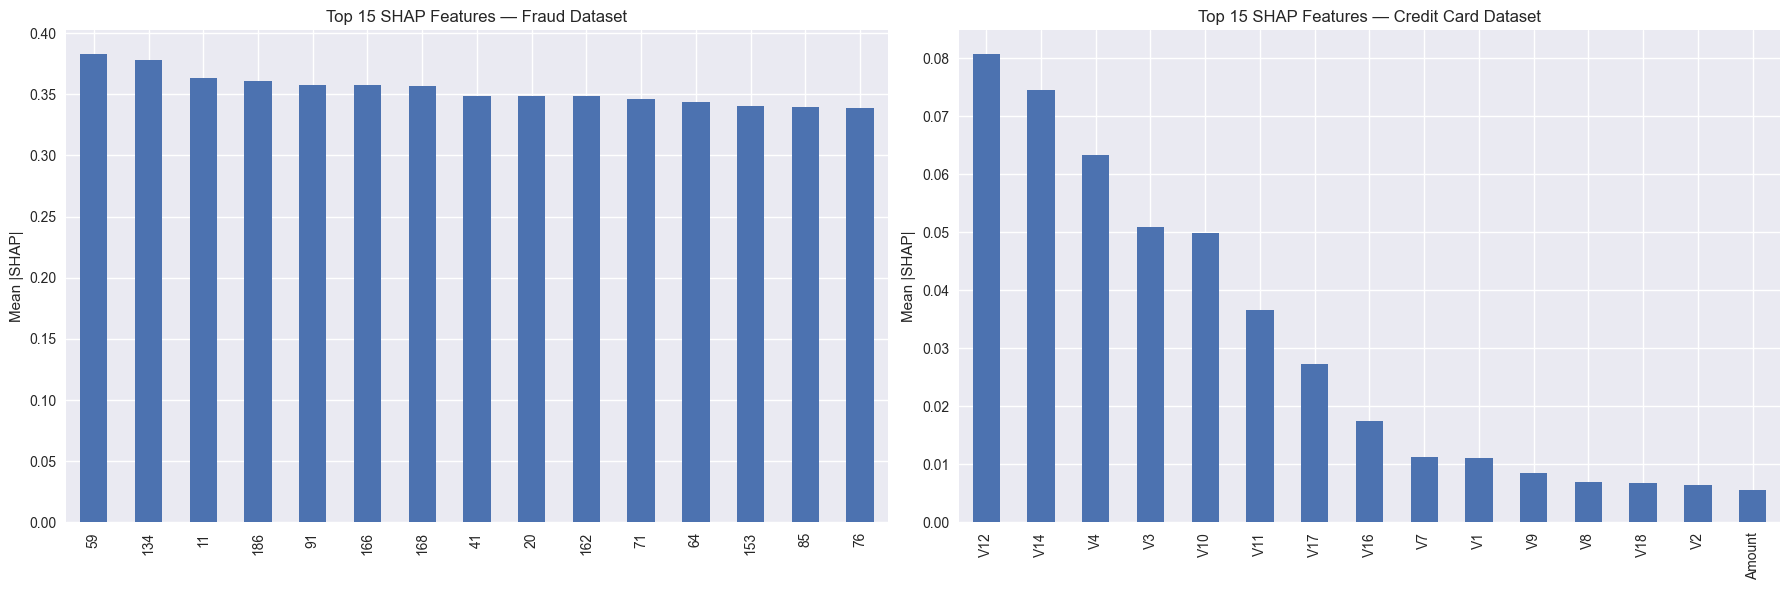

Fraud Dataset Beeswarm


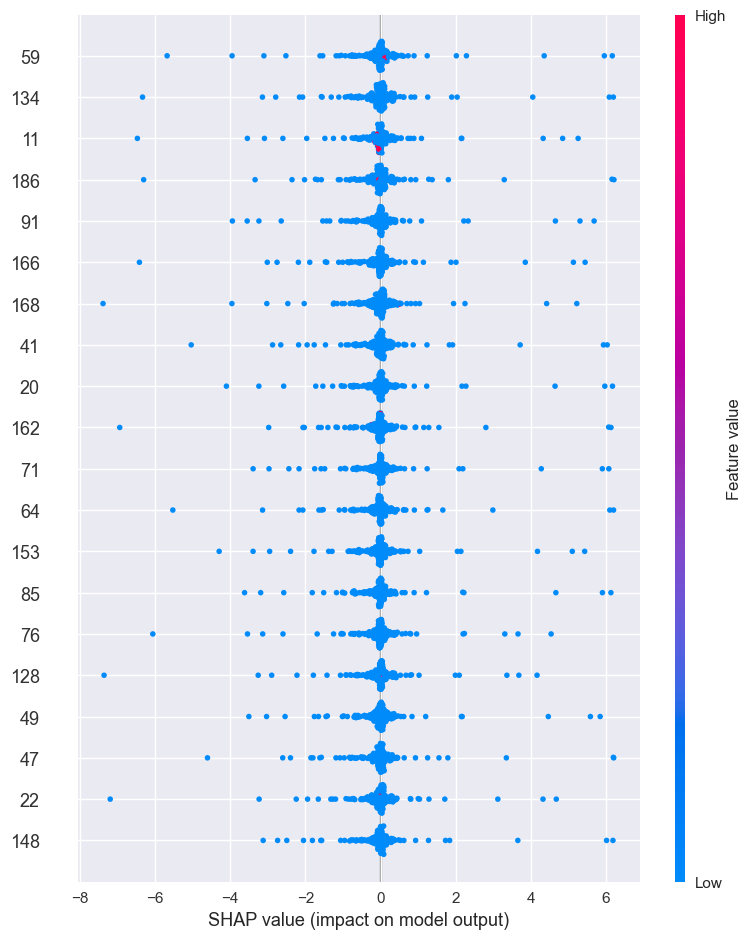

Credit Card Dataset Beeswarm


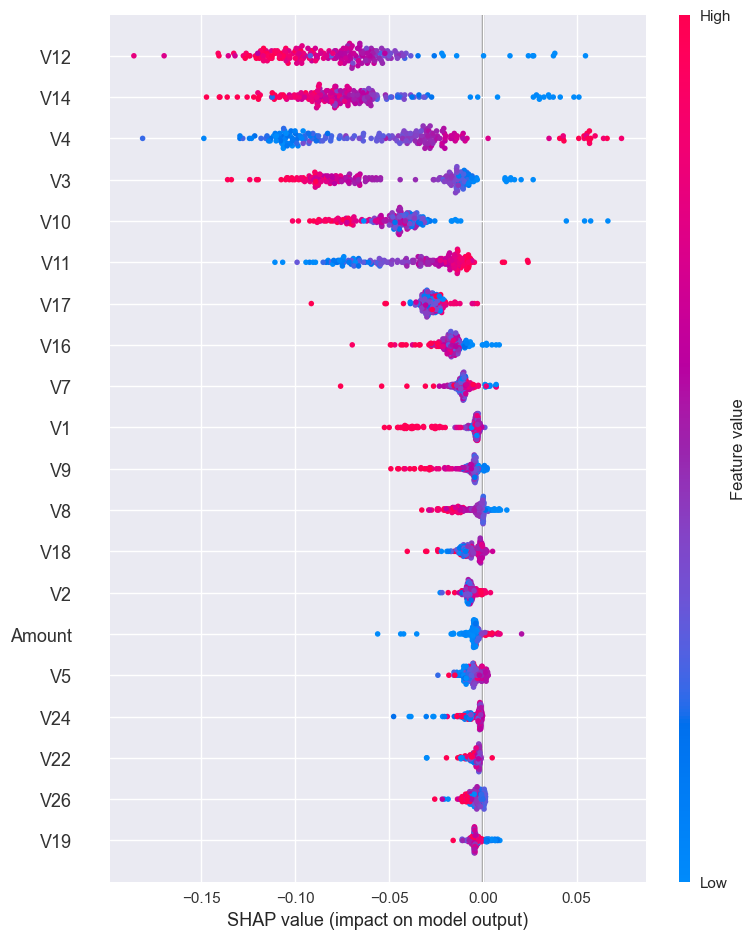

In [15]:


# ================= MEAN ABS SHAP =================
mean_abs_shap_fraud = np.mean(np.abs(shap_fraud), axis=0)
mean_abs_shap_cc = np.mean(np.abs(shap_cc), axis=0)

shap_importance_fraud = pd.Series(
    mean_abs_shap_fraud, index=X_fraud_df.columns
).sort_values(ascending=False)

shap_importance_cc = pd.Series(
    mean_abs_shap_cc, index=X_cc_df.columns
).sort_values(ascending=False)

# ================= BAR PLOTS =================
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
shap_importance_fraud.head(15).plot(kind="bar")
plt.title("Top 15 SHAP Features — Fraud Dataset")
plt.ylabel("Mean |SHAP|")

plt.subplot(1,2,2)
shap_importance_cc.head(15).plot(kind="bar")
plt.title("Top 15 SHAP Features — Credit Card Dataset")
plt.ylabel("Mean |SHAP|")

plt.tight_layout()
plt.show()

# ================= BEESWARM PLOTS =================
import shap

print("Fraud Dataset Beeswarm")
shap.summary_plot(shap_fraud, X_fraud_df)

print("Credit Card Dataset Beeswarm")
shap.summary_plot(shap_cc, X_cc_df)


In [16]:
import os
os.makedirs("shap_outputs", exist_ok=True)


### Combined SHAP Comparison Table (Fraud vs Credit)

In [17]:
# Top 15 each
fraud_top = shap_importance_fraud.head(15).reset_index()
fraud_top.columns = ["Feature", "Fraud_SHAP"]

cc_top = shap_importance_cc.head(15).reset_index()
cc_top.columns = ["Feature", "Credit_SHAP"]

# Merge both
combined_shap = pd.merge(fraud_top, cc_top, on="Feature", how="outer")

combined_shap = combined_shap.fillna(0).sort_values(
    by=["Fraud_SHAP","Credit_SHAP"], ascending=False
)

# Save
combined_shap.to_csv("shap_outputs/combined_shap_importance.csv", index=False)

combined_shap


,Feature,Fraud_SHAP,Credit_SHAP
9,59,0.383075,0.000000
1,134,0.378422,0.000000
0,11,0.363318,0.000000
6,186,0.360499,0.000000
14,91,0.357804,0.000000
4,166,0.357784,0.000000
5,168,0.357053,0.000000
8,41,0.348787,0.000000
7,20,0.348772,0.000000
3,162,0.348397,0.000000


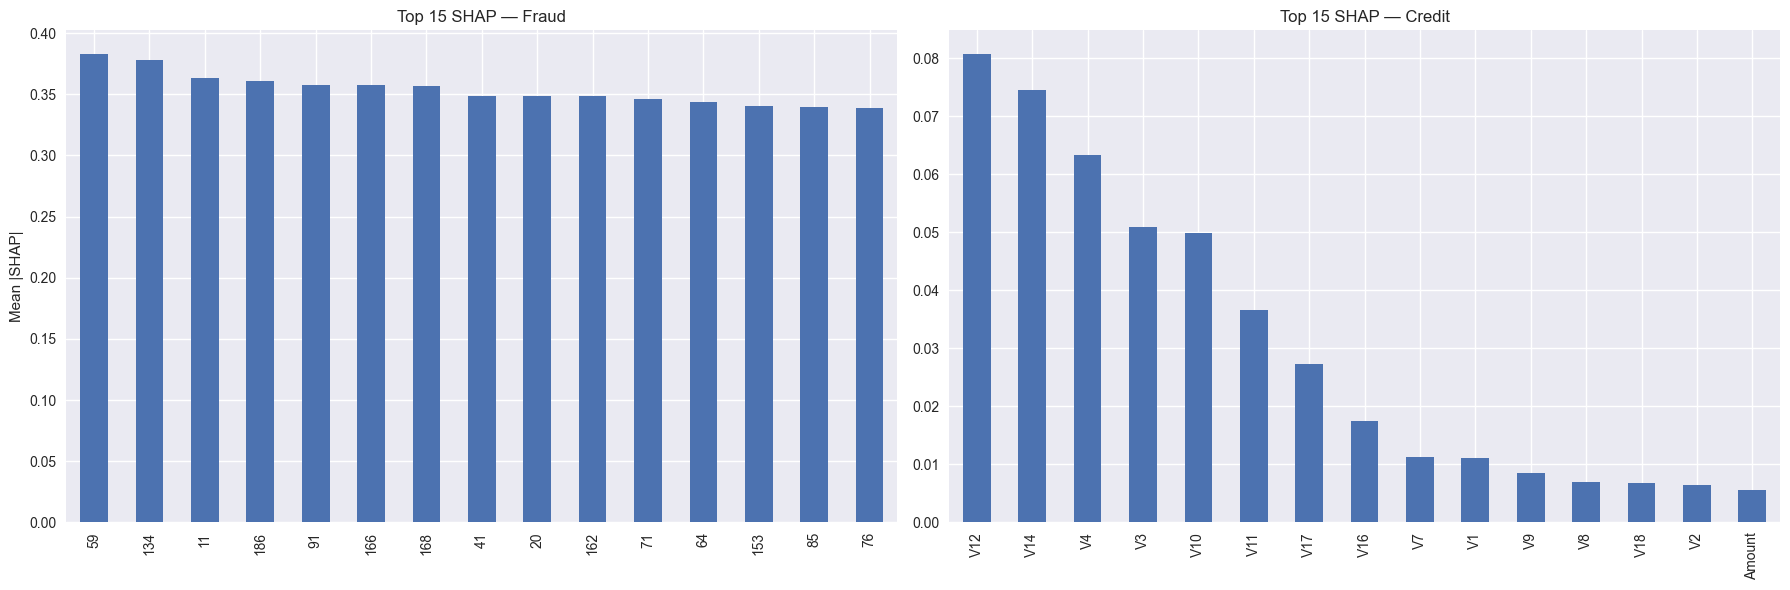

In [18]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
shap_importance_fraud.head(15).plot(kind="bar")
plt.title("Top 15 SHAP — Fraud")
plt.ylabel("Mean |SHAP|")

plt.subplot(1,2,2)
shap_importance_cc.head(15).plot(kind="bar")
plt.title("Top 15 SHAP — Credit")

plt.tight_layout()
plt.savefig("shap_outputs/shap_bar_comparison.png", dpi=300)
plt.show()


### saving plots

In [19]:
import os

# SHAP output folder at project root
SHAP_DIR = os.path.abspath(os.path.join("..", "shap_outputs"))
os.makedirs(SHAP_DIR, exist_ok=True)

# Fraud beeswarm
shap.summary_plot(shap_fraud, X_fraud_df, show=False)
plt.savefig(os.path.join(SHAP_DIR, "fraud_beeswarm.png"),
            dpi=300, bbox_inches="tight")
plt.close()

# Credit beeswarm
shap.summary_plot(shap_cc, X_cc_df, show=False)
plt.savefig(os.path.join(SHAP_DIR, "credit_beeswarm.png"),
            dpi=300, bbox_inches="tight")
plt.close()


### Helper Function (works for BOTH datasets)

In [30]:
import shap
import numpy as np
import os

def generate_force_plots(model, X_scaled, y_true, shap_values, X_df, dataset_name):

    # Handle binary SHAP properly
    if isinstance(shap_values, list):
        shap_vals = shap_values[1]
    else:
        shap_vals = shap_values[..., 1] if shap_values.ndim == 3 else shap_values

    shap_vals = np.array(shap_vals)

    preds = model.predict(X_scaled)

    # Find indices
    tp = np.where((preds == 1) & (y_true == 1))[0][0]
    fp = np.where((preds == 1) & (y_true == 0))[0][0]
    fn = np.where((preds == 0) & (y_true == 1))[0][0]

    print(f"\n{dataset_name} Examples:")
    print("TP index:", tp)
    print("FP index:", fp)
    print("FN index:", fn)

    explainer = shap.TreeExplainer(model)

    base_value = explainer.expected_value[1]

    os.makedirs("../shap_outputs/force", exist_ok=True)

    # ----- TRUE POSITIVE -----
    shap.force_plot(
        base_value,
        shap_vals[tp],
        X_df.iloc[tp],
        matplotlib=True,
        show=False
    )
    plt.title(f"{dataset_name} — True Positive")
    plt.savefig(f"../shap_outputs/force/{dataset_name}_TP.png", bbox_inches="tight", dpi=300)
    plt.close()

    # ----- FALSE POSITIVE -----
    shap.force_plot(
        base_value,
        shap_vals[fp],
        X_df.iloc[fp],
        matplotlib=True,
        show=False
    )
    plt.title(f"{dataset_name} — False Positive")
    plt.savefig(f"../shap_outputs/force/{dataset_name}_FP.png", bbox_inches="tight", dpi=300)
    plt.close()

    # ----- FALSE NEGATIVE -----
    shap.force_plot(
        base_value,
        shap_vals[fn],
        X_df.iloc[fn],
        matplotlib=True,
        show=False
    )
    plt.title(f"{dataset_name} — False Negative")
    plt.savefig(f"../shap_outputs/force/{dataset_name}_FN.png", bbox_inches="tight", dpi=300)
    plt.close()

    print(f"✅ Force plots saved for {dataset_name}")


In [31]:
y_fraud_sample = y_fraud.iloc[:X_fraud_s.shape[0]].values


### Force plots for fraud

In [32]:
generate_force_plots(
    fraud_rf,
    X_fraud_s,
    y_fraud_sample,     # FIXED
    shap_values_fraud,
    X_fraud_df,
    "Fraud"
)



Fraud Examples:
TP index: 110
FP index: 15
FN index: 26
✅ Force plots saved for Fraud


### Sample a subset with at least some positives

In [33]:
# Sample a subset with at least some positives
n_pos = 50   # number of fraud transactions
n_neg = 150  # number of non-fraud transactions

X_cc_pos = X_cc[y_cc == 1].sample(n=n_pos, random_state=42)
X_cc_neg = X_cc[y_cc == 0].sample(n=n_neg, random_state=42)

X_cc_s = pd.concat([X_cc_pos, X_cc_neg])
y_cc_sample = y_cc.loc[X_cc_s.index].values

# Recompute SHAP values for this subset
explainer_cc = shap.TreeExplainer(cc_rf, feature_perturbation="interventional")
shap_values_cc = explainer_cc.shap_values(X_cc_s, check_additivity=False)

X_cc_df = pd.DataFrame(X_cc_s, columns=X_cc.columns)


c:\Users\Administrator\Downloads\week12 new\Improved-detection-of-fraud-cases-for-e-commerce-and-bank-transactions-updated\.venv\Lib\site-packages\shap\explainers\_tree.py:254: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


### force plots for credit card

In [34]:
generate_force_plots(
    cc_rf,
    X_cc_s,
    y_cc_sample,
    shap_values_cc,
    X_cc_df,
    "CreditCard"
)


c:\Users\Administrator\Downloads\week12 new\Improved-detection-of-fraud-cases-for-e-commerce-and-bank-transactions-updated\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



CreditCard Examples:
TP index: 0
FP index: 69
FN index: 1
✅ Force plots saved for CreditCard
